In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from tqdm import tqdm

# Preparing DataLoaders

In [7]:
tfms = transforms.Compose([#transforms.Resize((16,16)),
                           transforms.ToTensor()])
                           #transforms.Normalize((0.5),(0.5))])

In [8]:
trainset = datasets.KMNIST('./data/KMNIST',train=True, download=True, transform=tfms)


valset = datasets.KMNIST('./data/KMNIST',train=False, download=True, transform=tfms)

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)

valloader = torch.utils.data.DataLoader(valset, batch_size=10, shuffle=False)

In [10]:
classes = trainloader.dataset.classes
classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

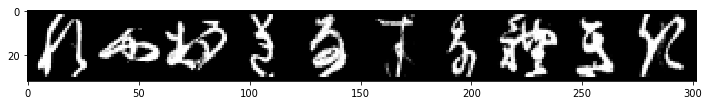

In [11]:
batch = next(iter(trainloader))
img,label = batch
images = torchvision.utils.make_grid(img,nrow=10)

plt.figure(figsize=(12,12))
plt.imshow(images.permute(1,2,0))

In [12]:
img.shape, label.shape

(torch.Size([10, 1, 28, 28]), torch.Size([10]))

In [39]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
else: 
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU


# Adaptive Learning Rate

To make learning rate adaptable.i.e. change by `adjust_lr_rate` every `adjust_every` epochs, add the line:

`if epoch % adjust_every == 0:  
    optimizer.param_groups[0]['lr'] *= adjust_lr_rate`

In [151]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(OrderedDict([
            ('conv1',nn.Conv2d(in_channels=1, out_channels=4, kernel_size=2)),
            ('fun1',nn.ReLU()),
            ('max1',nn.MaxPool2d(kernel_size=(2,2))),
            ('conv2',nn.Conv2d(in_channels=4, out_channels=8, kernel_size=2)),
            ('fun2',nn.ReLU())
            ]))
        self.layer2 = nn.Sequential(OrderedDict([
            ('lin1',nn.Linear(in_features=8*12*12, out_features=64)),
            ('fun1',nn.ReLU()),
            ('lin3',nn.Linear(in_features=64, out_features=10)),
            ]))
    
    def forward(self,x):
        x = self.layer1(x)
        x = x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        x = self.layer2(x)
        return x
    
    def learn(self,epochs,DataLoader,lr,adjust_lr_rate,adjust_every):
        loss_fun = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(),lr=lr,weight_decay=1e-4)
        
        z = torch.tensor([])
        for epoch in range(epochs):
            if epoch%adjust_every==0:optimizer.param_groups[0]['lr']*=adjust_lr_rate #here
            for data in DataLoader:
                X,y = data
                if torch.cuda.is_available(): X,y = X.to(device),y.to(device)
                
                optimizer.zero_grad()
                output = self(X)
                loss = loss_fun(output,y)
                loss.backward()
                
                #z = torch.cat((z,loss),dim=0)
                optimizer.step()
            print(epoch,round(optimizer.param_groups[0]['lr'],5), loss.item())
        #return z
    
    @torch.no_grad()
    def accuracy(self,DataLoader):
        correct=0
        total=0
        
        for data in tqdm(DataLoader):
            X,y = data
            if torch.cuda.is_available(): X,y = X.to(device),y.to(device)
            predict = self(X)
            for idx,i in enumerate(predict):
                if torch.argmax(i,dim=-1)==y[idx]:
                    correct +=1
                total +=1
        print('Accuracy : {}'.format(round(correct/total*100,3)))
        
    
net = Net().to(device)

In [ ]:
net(img.to(device)).shape

In [ ]:
net.learn(8,trainloader,1e-1,0.1,3)

In [ ]:
net.accuracy(trainloader)

In [ ]:
net.accuracy(valloader)

In [ ]:
'''Predict All'''
predict_all = torch.tensor([]).to(device)
actual_all = torch.tensor([],dtype=torch.int64).to(device)
with torch.no_grad():
    for Xp,yp in tqdm(valloader):
        if torch.cuda.is_available(): Xp,yp = Xp.to(device),yp.to(device)
        predict = net(Xp)
        predict_all = torch.cat((predict_all, predict))
        actual_all = torch.cat((actual_all, yp))

In [ ]:
stack = torch.stack((predict_all.argmax(dim=1),actual_all),dim=1)

In [ ]:
con = torch.zeros(10,10)
for i,j in stack:
    con[i,j] +=1
con.dtype

In [ ]:
con.detach_()

In [ ]:
con = con.int()

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(con,classes)

# Enlarge Photos and Adjust CNN

In [81]:
tfms_tt = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ToTensor()])
tfms_tv = transforms.Compose([
        transforms.ToTensor()])

In [82]:
trainset_t = datasets.KMNIST('./data/KMNIST/224',train=True, download=True, transform=tfms_tt)


valset_t = datasets.KMNIST('./data/KMNIST/224',train=False, download=True, transform=tfms_tv)

In [83]:
trainloader_t = torch.utils.data.DataLoader(trainset_t, batch_size=10, shuffle=True)

valloader_t = torch.utils.data.DataLoader(valset_t, batch_size=10, shuffle=False)

In [84]:
batch_t = next(iter(trainloader_t))
Xt,yt = batch_t

In [105]:
Xt.shape

torch.Size([10, 1, 28, 28])

In [125]:
class Net_E(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(OrderedDict([
            ('conv1',nn.Conv2d(in_channels=1, out_channels=6, kernel_size=2)),
            ('fun1',nn.ReLU()),
            ('max1',nn.MaxPool2d(kernel_size=(2,2))),
            ('conv2',nn.Conv2d(in_channels=6, out_channels=12, kernel_size=2)),
            ('fun2',nn.ReLU())
            ]))
        self.layer2 = nn.Sequential(OrderedDict([
            ('lin1',nn.Linear(in_features=12*12*12, out_features=216)),
            ('fun1',nn.ReLU()),
            ('lin3',nn.Linear(in_features=216, out_features=10)),
            ]))
    
    def forward(self,x):
        x = self.layer1(x)
        x = x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        x = self.layer2(x)
        return x
    
    def learn(self,epochs,DataLoader,lr,adjust_lr_rate,adjust_every):
        loss_fun = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(),lr=lr,weight_decay=1e-4)
        
        z = torch.tensor([])
        for epoch in range(epochs):
            if epoch%adjust_every==0:optimizer.param_groups[0]['lr']*=adjust_lr_rate
            for data in DataLoader:
                X,y = data
                if torch.cuda.is_available(): X,y = X.to(device),y.to(device)
                
                optimizer.zero_grad()
                output = self(X)
                loss = loss_fun(output,y)
                loss.backward()
                
                #z = torch.cat((z,loss),dim=0)
                optimizer.step()
            print(epoch,round(optimizer.param_groups[0]['lr'],5), loss.item())
        #return z
    
    @torch.no_grad()
    def accuracy(self,DataLoader):
        correct=0
        total=0
        
        for data in tqdm(DataLoader):
            X,y = data
            if torch.cuda.is_available(): X,y = X.to(device),y.to(device)
            predict = self(X)
            for idx,i in enumerate(predict):
                if torch.argmax(i,dim=-1)==y[idx]:
                    correct +=1
                total +=1
        print('Accuracy : {}'.format(round(correct/total*100,3)))
        
    
net_t = Net_E().to(device)

In [106]:
net_t(Xt.to(device)).shape

torch.Size([10, 10])

In [111]:
net_t.learn(3,trainloader_t,1e-3,0.1,2)

0 0.0001 0.13448691368103027
1 0.0001 0.006481075193732977
2 1e-05 0.06747722625732422


In [112]:
net_t.accuracy(valloader_t)

100%|██████████| 1000/1000 [00:02<00:00, 452.16it/s]

Accuracy : 90.36


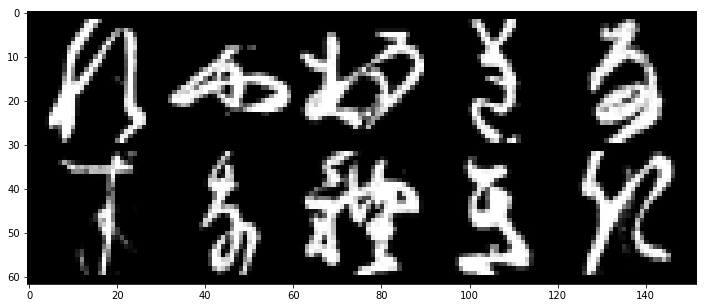

In [114]:
images = torchvision.utils.make_grid(img,nrow=5)
plt.figure(figsize=(12,12))
plt.imshow(images.permute(1,2,0))

Enlarging photos didn't improve predictability, on the countrary it reduced it!!

# Joining both datasets and retain the network

In [116]:
trainset, valset

(Dataset KMNIST
     Number of datapoints: 60000
     Root location: ./data/KMNIST
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ), Dataset KMNIST
     Number of datapoints: 10000
     Root location: ./data/KMNIST
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

In [118]:
joinset = torch.utils.data.ConcatDataset((trainset,valset))

In [119]:
joinset.datasets

[Dataset KMNIST
     Number of datapoints: 60000
     Root location: ./data/KMNIST
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ), Dataset KMNIST
     Number of datapoints: 10000
     Root location: ./data/KMNIST
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            )]

In [165]:
joinloader = torch.utils.data.DataLoader(joinset,batch_size=10,shuffle=True,num_workers=2)

In [166]:
netj= Net()

In [167]:
netj.to(device)

Net(
  (layer1): Sequential(
    (conv1): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1))
    (fun1): ReLU()
    (max1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
    (fun2): ReLU()
  )
  (layer2): Sequential(
    (lin1): Linear(in_features=1152, out_features=64, bias=True)
    (fun1): ReLU()
    (lin3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [168]:
netj.learn(5,joinloader,1e-1,1,5)

0 0.1 0.5354361534118652
1 0.1 0.05742249637842178
2 0.1 0.07460732758045197
3 0.1 0.1451323926448822
4 0.1 0.00015506744966842234


In [169]:
netj.accuracy(joinloader)

100%|██████████| 7000/7000 [00:16<00:00, 415.39it/s]

Accuracy : 98.094


In [170]:
netj.accuracy(valloader)

100%|██████████| 1000/1000 [00:02<00:00, 441.93it/s]

Accuracy : 96.76
